# Build a Dataset of Finger Tapping Single Shots

In [3]:
import essentia
import essentia.standard as estd
import IPython
import numpy as np
import os
import sys
import freesound
import matplotlib.pyplot as plt
%matplotlib inline

from requests_oauthlib import OAuth2Session
from flask import Flask, request, redirect, session, url_for
from flask.json import jsonify
from pathlib import Path
from tempfile import TemporaryDirectory

plt.style.use('ggplot')

## Retrieve Sounds from Freesound.org

**this requires OAuth2 authentication**

In [4]:
client_id = "x7MOm9K8aUcPUESY5Odq"
client_secret = "4IIgOrla9TPwePUF0kkaltAIoJ5LZFvgRhBcDhvP"
oauth = OAuth2Session(client_id)
authorization_url, state = oauth.authorization_url(
    "https://freesound.org/apiv2/oauth2/authorize/"
)
print(f"Please go to {authorization_url} and authorize access.")

authorization_code = input("Please enter the authorization code:")
oauth_token = oauth.fetch_token(
    "https://freesound.org/apiv2/oauth2/access_token/",
    authorization_code,
    client_secret=client_secret,
)
client = freesound.FreesoundClient()
client.set_token(oauth_token["access_token"], "oauth")

Please go to https://freesound.org/apiv2/oauth2/authorize/?response_type=code&client_id=x7MOm9K8aUcPUESY5Odq&state=wy4X4JuOAeIjpt2NmRCICCcxtfptlK and authorize access.


In [5]:
# Set the search query and the number of results you want to download (N)
search_query = "finger-tapping"
num_results_to_download = 5
dest_path = "../data/freesound"
os.makedirs(dest_path, exist_ok=True)

results_pager = client.text_search(
    query=search_query, 
    fields="id,name,previews", 
    sort="rating_desc",
    descriptors_filter="duration:[0 TO 10]"
)

for sound in results_pager:
    print("\t\tDownloading:", sound.name)
    
    filename = sound.name.replace(" ", "_") + ".wav"
    sound.retrieve(dest_path, name=filename)

    if not results_pager.next_page():
        break

    results_pager.next_page()

		Downloading: book handling
		Downloading: Squeak Rusty Metal Water Tap
		Downloading: keyboard typing old
		Downloading: SunBurst
		Downloading: Tink3d.wav
		Downloading: Menu FX 03 (normal).wav
		Downloading: itching a scratch.WAV
		Downloading: Glass Tap No Liquid.WAV
		Downloading: Wine Glass Toast Clink
		Downloading: Decapitation.wav
		Downloading: Big glass bell ringing
		Downloading: FOLEY_Sliding fingers down cloth ribbon_1.wav
		Downloading: Percussive Hit 01_06
		Downloading: water, tap, dripping.WAV
		Downloading: finger tap table counter wood various.wav


## Onset-based Audio Segmentation with Essentia: Cutting and Saving Segments

In [6]:
filename = "../data/finger_tapping_sequence.wav"

loader = estd.MonoLoader(filename=filename)
replay_gain = estd.ReplayGain()

audio = loader()
audio = estd.DCRemoval()(audio)
gain_value = replay_gain(audio)
audio = estd.Scale(factor = 10**((gain_value)/20))(audio)

In [7]:
# 1. Compute the onset detection function
od_hfc = estd.OnsetDetection(method='hfc')
od_complex = estd.OnsetDetection(method='complex')

# We need the auxilary algorithms to compute magnitude and phase.
w = estd.Windowing(type='hann')
fft = estd.FFT() # Outputs a complex FFT vector.
c2p = estd.CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# # # Compute both ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in estd.FrameGenerator(audio, frameSize=1024, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.hfc', od_hfc(magnitude, phase))
    pool.add('odf.complex', od_complex(magnitude, phase))

# help(estd.FrameCutter)

In [8]:
# 2. Detect onset locations.
onsets = estd.Onsets()

onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                    essentia.array([pool['odf.hfc']]),
                    # You need to specify weights, but if we use only one ODF
                    # it doesn't actually matter which weight to give it
                    [1])

onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])

# Add onset markers to the audio and save it to a file.
# We use beeps instead of white noise and stereo signal as it's more distinctive.

# We want to keep beeps in a separate audio channel.
# Add them to a silent audio and use the original audio as another channel. Mux both into a stereo signal.
silence = [0.] * len(audio)

beeps_hfc = estd.AudioOnsetsMarker(onsets=onsets_hfc, type='beep')(silence)
beeps_complex = estd.AudioOnsetsMarker(onsets=onsets_complex, type='beep')(silence)

# print(onsets_complex)

audio_hfc = estd.StereoMuxer()(audio, beeps_hfc)
audio_complex = estd.StereoMuxer()(audio, beeps_complex)

# Write audio to files in a temporary directory.
temp_dir = TemporaryDirectory()
estd.AudioWriter(filename=temp_dir.name + '/tmp_onsets_hfc_stereo.mp3', format='mp3')(audio_hfc)
estd.AudioWriter(filename=temp_dir.name + '/tmp_onsets_complex_stereo.mp3', format='mp3')(audio_complex)

[mp3 @ 0x7fa9b7cf3600] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[mp3 @ 0x7fa9b7cf3600] Encoder did not produce proper pts, making some up.
[mp3 @ 0x7fa9c4836e00] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.


In [9]:
IPython.display.Audio(temp_dir.name + '/tmp_onsets_hfc_stereo.mp3')

In [10]:
IPython.display.Audio(temp_dir.name + '/tmp_onsets_complex_stereo.mp3')

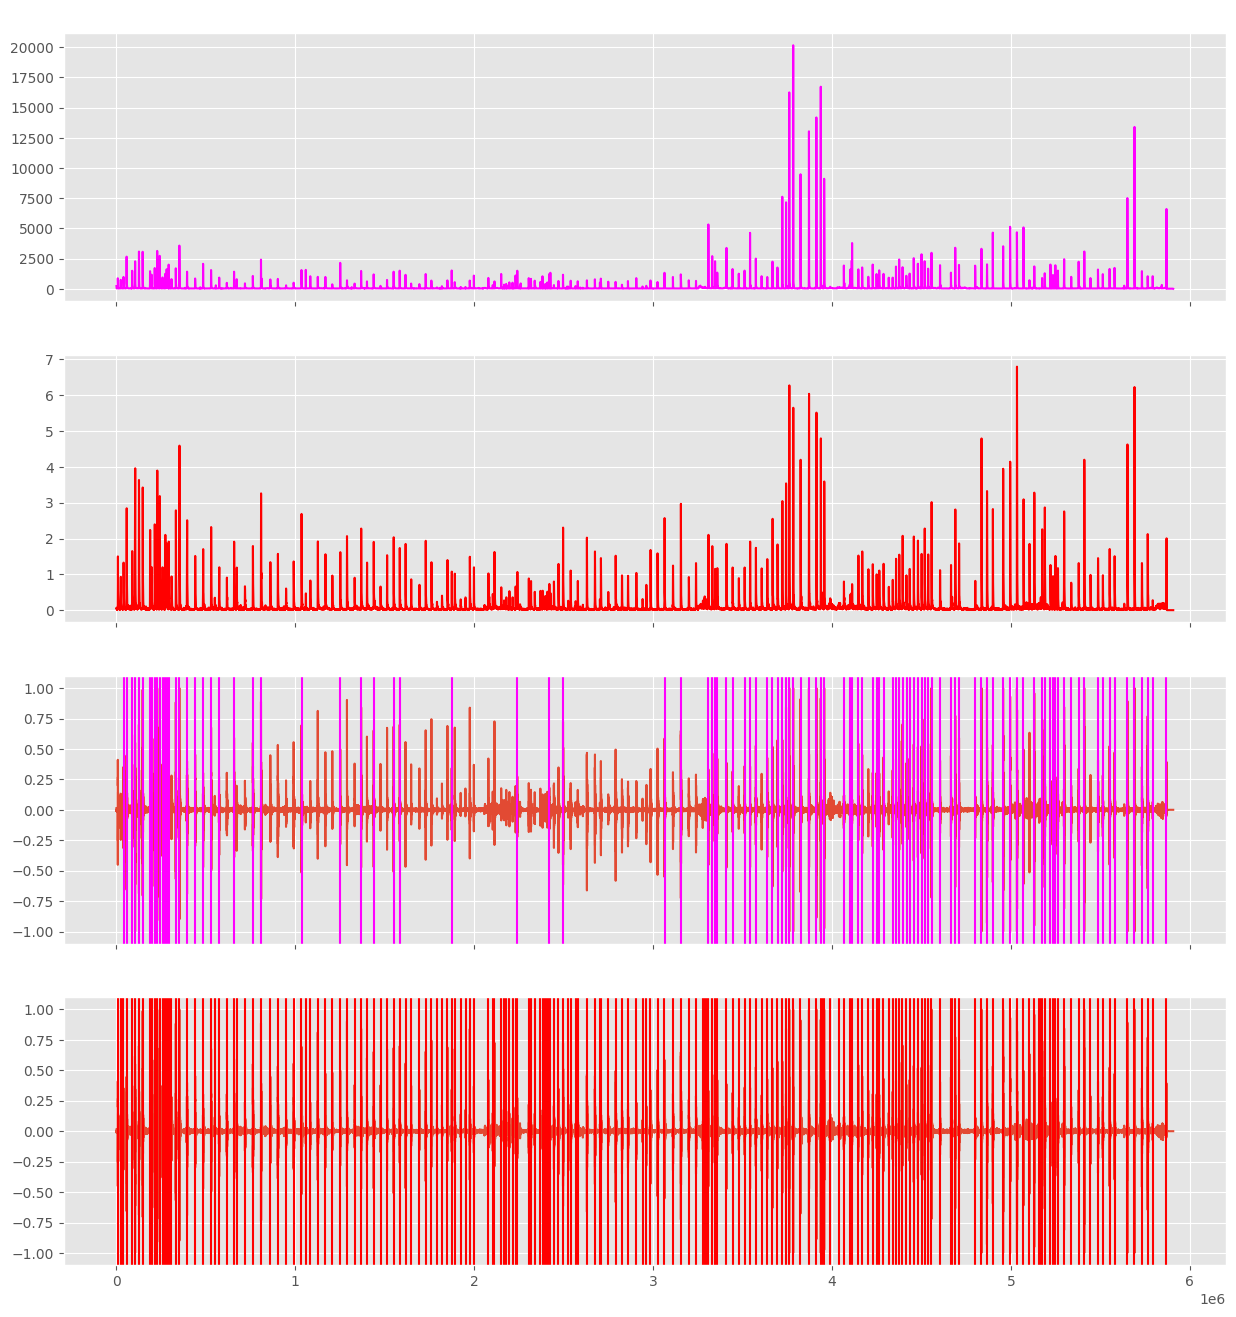

In [11]:
n_frames = len(pool['odf.hfc'])
frames_position_samples = np.array(range(n_frames)) * 512

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(15, 16))

ax1.set_title('HFC ODF')
ax1.plot(frames_position_samples, pool['odf.hfc'], color='magenta')

ax2.set_title('Complex ODF')
ax2.plot(frames_position_samples, pool['odf.complex'], color='red')

ax3.set_title('Audio waveform and the estimated onset positions (HFC ODF)')
ax3.plot(audio)
for onset in onsets_hfc:
    ax3.axvline(x=onset*44100, color='magenta')

ax4.set_title('Audio waveform and the estimated onset positions (complex ODF)')
ax4.plot(audio)
for onset in onsets_complex:
    ax4.axvline(x=onset*44100, color='red')

In [12]:
output_dir = "../data/finger_tapping/"
os.makedirs(output_dir, exist_ok=True)

# Convert numpy float32 arrays to Python lists
onset_times_hfc_list = list(onsets_hfc)
onset_times_complex_list = list(onsets_complex)

# Function to cut audio around each onset
def cut_audio_around_onsets(audio, onset_times, output_dir):
    for i, onset_time in enumerate(onset_times):
        start_time = max(0, onset_time - 0.00)
        end_time = onset_times[i + 1] if i + 1 < len(onset_times) else len(audio)
        end_time = min(len(audio), end_time + 0.0)

        # Extract the portion of audio
        onset_audio = audio[int(start_time * 44100):int(end_time * 44100)]

        # Save the onset audio to a file
        output_filename = os.path.join(output_dir, f'onset_{i + 1}.wav')
        estd.MonoWriter(filename=output_filename, format='wav')(onset_audio)

# Cut audio around onsets for both methods
# cut_audio_around_onsets(audio_hfc, onset_times_hfc_list, output_dir)

cut_audio_around_onsets(audio_complex[:, 0], onset_times_complex_list, output_dir)

[wav @ 0x7fa9c4118c00] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x7fa9ba04cc00] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x7fa9c411a400] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x7fa9c411a400] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x7fa9c50e4800] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x7fa9c411a400] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x7fa9b9031600] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x7fa9c506a800] Using AVStream.codec.time_base as a timebase h